Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами
Цель: В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

Часть 1. Парсинг

По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).
Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.

In [39]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек 
import time          # Библиотека для времени

# подгрузим один из методов этой библиотеки
from fake_useragent import UserAgent

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from itertools import groupby
import re
# подгрузим один из методов этой библиотеки
from fake_useragent import UserAgent
from ftfy import fix_text
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
import pymorphy2
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle 

[nltk_data] Downloading package punkt to /home/nata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
link = 'https://cdek.market/'

In [3]:
main_page = 'https://cdek.market/c/307/telefony-i-aksessuary/'

In [4]:
def get_soup(page_link:str):
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    if not response.ok:
        return []
    
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In [5]:
electronik_soup = get_soup(main_page)

In [6]:
def get_ref(div_class, soup):
    _refs = []
    try:
        refs = soup.find("div", attrs={'class':div_class})
        refs = refs.findAll("a")
        for cat in refs:
            if 'href' in cat.attrs: 
                _refs.append(cat.attrs['href'])
        _refs = [el for el, _ in groupby(_refs)]
    except:
        print("Something went wrong")
    finally: 
        return _refs

In [7]:
categories = get_ref('ty-pagination__items', electronik_soup)

In [8]:
categories

['https://cdek.market/c/307/telefony-i-aksessuary/page-2/',
 'https://cdek.market/c/307/telefony-i-aksessuary/page-3/',
 'https://cdek.market/c/307/telefony-i-aksessuary/page-4/',
 'https://cdek.market/c/307/telefony-i-aksessuary/page-5/',
 'https://cdek.market/c/307/telefony-i-aksessuary/page-6/',
 'https://cdek.market/c/307/telefony-i-aksessuary/page-7/',
 'https://cdek.market/c/307/telefony-i-aksessuary/page-8/']

Достаем инфу по товарам

In [9]:
category_refs = []
for category in categories:
    product_soup = get_soup(category)
    _category_refs = get_ref('grid-list', product_soup)
    category_refs = category_refs + _category_refs

In [10]:
category_refs[0]

'https://cdek.market/p/231002/kreplenie-smartfona-na-armaturu-scepleniya-tormoza-x-grip-korotkiy-rychag-nu-trubu-s-u-skoboy-v-sbore/'

In [11]:
product_soup = get_soup(category_refs[15])
    

In [12]:
name = product_soup.find("h1").text
name

'Крепление смартфона на струбцине X-Grip® (короткий рычаг, в сборе)'

In [13]:
text_about = product_soup.find("div", attrs={'class':"ty-wysiwyg-content content-description"}).text.strip()
text_about[:500]

'Крепление состоит из универсального держателя с подпружиненным зажимом, который на шарнирном соединении через короткий рычаг 60мм., соединен с креплением-струбциной, которая может быть установлена на круглые/овальные трубы диаметром от 1,6 см до 3,8 см (0,625"- 1,5"). Универсальный держатель имеет искусную и умную конструкцию с четырьмя подпружиненными опорами, которые надежно фиксируют смартфон с достаточной силой, не закрывая собой экран. В нашем магазине большой ассортимент креплений Rammount'

In [14]:
amount = product_soup.find("span", attrs={"class":"ty-qty-in-stock ty-control-group__item"}).text.strip()
num_list = int(re.sub('[^0-9]+', '', amount))
num_list

17

In [15]:
def get_product_info(product_link):
    try:
        product_soup = get_soup(product_link)
        name = product_soup.find("h1").text.strip()
        text_about = product_soup.find("div", attrs={'class':"ty-wysiwyg-content content-description"}).text.strip()
        amount = product_soup.find("span", attrs={"class":"ty-qty-in-stock ty-control-group__item"}).text.strip()
        price = product_soup.find("span", attrs={"class":"ty-price-num"}).text.strip()
        amount = re.sub('[^0-9]+', '', amount)
        price = re.sub('[^0-9.]+', '', price)
    except:
        name = ''
        text_about = ''
        amount = '0'
        price = '0'
    return {'name':name, 'text':text_about, 'amount':amount, 'price':price}

In [16]:
def get_products_info_df(main_page):
    products_info = []
    electronik_soup = get_soup(main_page)
    pages = get_ref('ty-pagination__items', electronik_soup)
    pages.append(main_page)
    for page in pages:
        page_soup = get_soup(page)
        category_refs = get_ref('grid-list', page_soup)
        for category_ref in category_refs:
            _info = {}
            _info = get_product_info(category_ref)
            if _info['name'] and _info not in products_info:
                product_info = {}
                product_info['category'] = category_ref
                product_info.update(_info)
                products_info.append(product_info)
            time.sleep(0.3)
    products_df = pd.DataFrame(products_info)
    return products_df

In [26]:
products_df = get_products_info_df(main_page)

In [32]:
products_df = products_df.drop_duplicates(['name','text','price'], keep='last')

In [33]:
products_df.head(10)

,category,name,text,amount,price
3,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на арматуру сцепления/торм...,Универсальное крепление состоит из держателя с...,6,6800.00
7,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на арматуру руля X-Grip® (...,Крепление состоит из универсального держателя ...,6,6440.00
11,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (коротк...,Универсальное крепление состоит из держателя с...,13,5810.00
15,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на струбцине X-Grip® (коро...,Крепление состоит из универсального держателя ...,17,7610.00
19,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (станда...,Универсальное крепление RAM-B-149Z-A-UN10U сос...,13,6210.00
23,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (станда...,Универсальное крепление состоит из держателя с...,13,5830.00
27,https://cdek.market/index.php?dispatch=product...,Держатель смартфона X-Grip®,Универсальный держатель RAM-HOL-UN10BU имеет и...,32,3460.00
31,https://cdek.market/index.php?dispatch=product...,Держатель смартфона X-Grip®,Универсальный держатель RAM-HOL-UN7BU имеет ис...,22,3070.00
35,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на присоске X-Grip® (станд...,Универсальное крепление RAM-B-166-UN10U состои...,25,6440.00
39,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на адаптере AMP X-Grip® (с...,Универсальное крепление состоит из держателя с...,4,5380.00


In [34]:
products_df.to_csv('~/parse.csv')

# Часть 2. NLP

Часть 2. NLP

1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической
4. Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик
5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

Ручной анализ

In [3]:
data = pd.read_csv('~/parse.csv')

In [4]:
data.head(10)

,Unnamed: 0,category,name,text,amount,price
0,3,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на арматуру сцепления/торм...,Универсальное крепление состоит из держателя с...,6,6800.0
1,7,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на арматуру руля X-Grip® (...,Крепление состоит из универсального держателя ...,6,6440.0
2,11,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (коротк...,Универсальное крепление состоит из держателя с...,13,5810.0
3,15,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на струбцине X-Grip® (коро...,Крепление состоит из универсального держателя ...,17,7610.0
4,19,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (станда...,Универсальное крепление RAM-B-149Z-A-UN10U сос...,13,6210.0
5,23,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (станда...,Универсальное крепление состоит из держателя с...,13,5830.0
6,27,https://cdek.market/index.php?dispatch=product...,Держатель смартфона X-Grip®,Универсальный держатель RAM-HOL-UN10BU имеет и...,32,3460.0
7,31,https://cdek.market/index.php?dispatch=product...,Держатель смартфона X-Grip®,Универсальный держатель RAM-HOL-UN7BU имеет ис...,22,3070.0
8,35,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на присоске X-Grip® (станд...,Универсальное крепление RAM-B-166-UN10U состои...,25,6440.0
9,39,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на адаптере AMP X-Grip® (с...,Универсальное крепление состоит из держателя с...,4,5380.0


In [6]:
data.columns

Index(['Unnamed: 0', 'category', 'name', 'text', 'amount', 'price'], dtype='object')

In [10]:
data = data.drop(['Unnamed: 0'], axis=1)

In [11]:
data.head(10)

,category,name,text,amount,price
0,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на арматуру сцепления/торм...,Универсальное крепление состоит из держателя с...,6,6800.0
1,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на арматуру руля X-Grip® (...,Крепление состоит из универсального держателя ...,6,6440.0
2,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (коротк...,Универсальное крепление состоит из держателя с...,13,5810.0
3,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на струбцине X-Grip® (коро...,Крепление состоит из универсального держателя ...,17,7610.0
4,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (станда...,Универсальное крепление RAM-B-149Z-A-UN10U сос...,13,6210.0
5,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на U-скобе X-Grip® (станда...,Универсальное крепление состоит из держателя с...,13,5830.0
6,https://cdek.market/index.php?dispatch=product...,Держатель смартфона X-Grip®,Универсальный держатель RAM-HOL-UN10BU имеет и...,32,3460.0
7,https://cdek.market/index.php?dispatch=product...,Держатель смартфона X-Grip®,Универсальный держатель RAM-HOL-UN7BU имеет ис...,22,3070.0
8,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на присоске X-Grip® (станд...,Универсальное крепление RAM-B-166-UN10U состои...,25,6440.0
9,https://cdek.market/index.php?dispatch=product...,Крепление смартфона на адаптере AMP X-Grip® (с...,Универсальное крепление состоит из держателя с...,4,5380.0


Уберем проблемы с кодировкой ftfy

In [49]:
text = fix_text(text, normalization='NFKC')

Нормализация -
Приведение токенов к единому регистру, чтобы избавиться от поверхностной разницы в написании

In [ ]:
text = text.lower()

Разбиение на токены

In [50]:
tokens = nltk.word_tokenize(text)
tokens

['универсальное',
 'крепление',
 'состоит',
 'из',
 'держателя',
 'с',
 'подпружиненным',
 'зажимом',
 ',',
 'который',
 'на',
 'шарнирном',
 'соединении',
 'через',
 'короткий',
 'рычаг',
 '60мм.',
 ',',
 'соединен',
 'с',
 'кронштейном',
 'для',
 'установки',
 'на',
 'мотоцикл',
 'двумя',
 'болтами',
 'к',
 'хомуту',
 'арматуры',
 'сцепления',
 'или',
 'ручного',
 'тормоза',
 'с',
 'левой',
 'или',
 'с',
 'правой',
 'стороны',
 'или',
 'с',
 'помощью',
 'оцинкованной',
 'u-скобы',
 '(',
 '2шт',
 '.',
 'в',
 'комплекте',
 ')',
 'к',
 'трубе',
 'руля',
 'диаметром',
 'от',
 '1,3см',
 'до',
 '3,1см',
 '(',
 'от',
 '0.50',
 "''",
 'до',
 '1.25',
 "''",
 ')',
 '.',
 'u-скоба',
 'имеет',
 'черные',
 'пластиковые',
 'колпачки',
 ',',
 'скрывающие',
 'открытые',
 'участки',
 'резьбы',
 '.',
 'в',
 'комплекте',
 'так',
 'же',
 'специальная',
 'вставка',
 ',',
 'позволяющая',
 'устанавливать',
 'хомут',
 'на',
 'тонкую',
 'трубу',
 '?',
 'до',
 '1,3',
 'см',
 '.',
 'универсальный',
 'держатель

Удаляем пунктуацию

In [51]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [52]:
tokens = [x for x in tokens if x not in string.punctuation]
tokens

['универсальное',
 'крепление',
 'состоит',
 'из',
 'держателя',
 'с',
 'подпружиненным',
 'зажимом',
 'который',
 'на',
 'шарнирном',
 'соединении',
 'через',
 'короткий',
 'рычаг',
 '60мм.',
 'соединен',
 'с',
 'кронштейном',
 'для',
 'установки',
 'на',
 'мотоцикл',
 'двумя',
 'болтами',
 'к',
 'хомуту',
 'арматуры',
 'сцепления',
 'или',
 'ручного',
 'тормоза',
 'с',
 'левой',
 'или',
 'с',
 'правой',
 'стороны',
 'или',
 'с',
 'помощью',
 'оцинкованной',
 'u-скобы',
 '2шт',
 'в',
 'комплекте',
 'к',
 'трубе',
 'руля',
 'диаметром',
 'от',
 '1,3см',
 'до',
 '3,1см',
 'от',
 '0.50',
 "''",
 'до',
 '1.25',
 "''",
 'u-скоба',
 'имеет',
 'черные',
 'пластиковые',
 'колпачки',
 'скрывающие',
 'открытые',
 'участки',
 'резьбы',
 'в',
 'комплекте',
 'так',
 'же',
 'специальная',
 'вставка',
 'позволяющая',
 'устанавливать',
 'хомут',
 'на',
 'тонкую',
 'трубу',
 'до',
 '1,3',
 'см',
 'универсальный',
 'держатель',
 'имеет',
 'искусную',
 'и',
 'умную',
 'конструкцию',
 'с',
 'четырьмя',
 

Убираем Стоп-слова - Наиболее частые слова в языке, не содержащие никакой информации о содержании текста

In [43]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/nata/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
len(stopwords.words('russian'))

151

In [46]:
print (' '.join(stopwords.words('russian')[:20]))

и в во не что он на я с со как а то все она так его но да ты


In [53]:
tokens = [x for x in tokens if x not in stopwords.words('russian')]
tokens

['универсальное',
 'крепление',
 'состоит',
 'держателя',
 'подпружиненным',
 'зажимом',
 'который',
 'шарнирном',
 'соединении',
 'короткий',
 'рычаг',
 '60мм.',
 'соединен',
 'кронштейном',
 'установки',
 'мотоцикл',
 'двумя',
 'болтами',
 'хомуту',
 'арматуры',
 'сцепления',
 'ручного',
 'тормоза',
 'левой',
 'правой',
 'стороны',
 'помощью',
 'оцинкованной',
 'u-скобы',
 '2шт',
 'комплекте',
 'трубе',
 'руля',
 'диаметром',
 '1,3см',
 '3,1см',
 '0.50',
 "''",
 '1.25',
 "''",
 'u-скоба',
 'имеет',
 'черные',
 'пластиковые',
 'колпачки',
 'скрывающие',
 'открытые',
 'участки',
 'резьбы',
 'комплекте',
 'специальная',
 'вставка',
 'позволяющая',
 'устанавливать',
 'хомут',
 'тонкую',
 'трубу',
 '1,3',
 'см',
 'универсальный',
 'держатель',
 'имеет',
 'искусную',
 'умную',
 'конструкцию',
 'четырьмя',
 'подпружиненными',
 'опорами',
 'которые',
 'надежно',
 'фиксируют',
 'смартфон',
 'фаблет',
 'достаточной',
 'силой',
 'закрывая',
 'собой',
 'экран',
 'запатентованная',
 'система',
 '

Нормализация - Стемминг и Лемматизация
Приведение грамматических форм слова и однокоренных слов к единой основе (lemma):

Стемминг – это грубый эвристический процесс, который отрезает «лишнее» от корня слов, часто это приводит к потере словообразовательных суффиксов.

Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.

Стемминг (для русского не огонь. Пока без него обойдемся)

In [56]:
#Пример использования Stemmer
from nltk.stem.snowball import RussianStemmer
r = RussianStemmer()
print(r.stem('Авиация'))
print(r.stem('национальный'))
print(r.stem('переобучение'))

авиац
национальн
переобучен


Лемматизация
(обычно лучше работает для сложных языков, в том числе для русского)

In [60]:
morph = pymorphy2.MorphAnalyzer()
tokens = [morph.normal_forms(x)[0] for x in tokens]
tokens = [x for x in tokens if x != "''"]
tokens

Представление документов

Мешок слов

In [147]:
dvectorizer = DictVectorizer(sparse=False)
document_bags = list()
bag = Counter()

for t in tokens:     
    bag[t] += 1
document_bags.append(bag)

df = pd.DataFrame(dvectorizer.fit_transform(document_bags), columns=dvectorizer.feature_names_)
df.head(10)

,0.50,"1,3","1,3см",1.25,2шт,"3,1см",60мм.,rammounts,u-скоба,арматура,...,участок,фабгод,фиксировать,хомут,четыре,чёрный,шар,шарнир,шарнирный,экран
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


Вся обработка что выше, но автоматичски

In [85]:
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))
sklearn_vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(1,1))
text = [data['name'][0]+data['text'][0]]
bow = sklearn_vectorizer.fit_transform(text)
bow

<1x98 sparse matrix of type '<class 'numpy.int64'>'
	with 98 stored elements in Compressed Sparse Row format>

In [136]:
text2 = [data['name'][0]+ ' ' + data['text'][0]]
text2

['Крепление смартфона на арматуру сцепления/тормоза X-Grip® (короткий рычаг, ну трубу с U-скобой, в сборе)Универсальное крепление состоит из держателя с подпружиненным зажимом, который на шарнирном соединении через короткий рычаг 60мм., соединен с кронштейном для установки на мотоцикл двумя болтами к хомуту арматуры сцепления или ручного тормоза с левой или с правой стороны или с помощью оцинкованной U-скобы (2шт. в комплекте) к трубе руля диаметром от 1,3см до 3,1см (от 0.50" до 1.25"). U-скоба имеет черные пластиковые колпачки, скрывающие открытые участки резьбы. В комплекте так же специальная вставка, позволяющая устанавливать хомут на тонкую трубу ? до 1,3 см. Универсальный держатель имеет искусную и умную конструкцию с четырьмя подпружиненными опорами, которые надежно фиксируют смартфон или фаблет с достаточной силой, не закрывая собой экран. Запатентованная система шарниров, состоящих из прорезиненного шара на держателе и U-скобе, и посадочных гнезд на связующих их рычаге позволя

In [86]:
bow.todense()

matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [87]:
sklearn_vectorizer.vocabulary_

{'универсальное': 83,
 'крепление': 30,
 'состоит': 71,
 'держателя': 16,
 'подпружиненным': 46,
 'зажимом': 19,
 'который': 29,
 'шарнирном': 95,
 'соединении': 70,
 'короткий': 27,
 'рычаг': 57,
 '60мм': 5,
 'соединен': 69,
 'кронштейном': 32,
 'установки': 86,
 'мотоцикл': 36,
 'двумя': 13,
 'болтами': 9,
 'хомуту': 91,
 'арматуры': 7,
 'сцепления': 75,
 'ручного': 56,
 'тормоза': 77,
 'левой': 33,
 'правой': 52,
 'стороны': 74,
 'помощью': 50,
 'оцинкованной': 44,
 'скобы': 64,
 '2шт': 2,
 'комплекте': 25,
 'трубе': 78,
 'руля': 55,
 'диаметром': 17,
 '3см': 3,
 '1см': 0,
 '50': 4,
 '25': 1,
 'скоба': 62,
 'имеет': 22,
 'черные': 92,
 'пластиковые': 45,
 'колпачки': 24,
 'скрывающие': 65,
 'открытые': 43,
 'участки': 87,
 'резьбы': 54,
 'специальная': 73,
 'вставка': 11,
 'позволяющая': 49,
 'устанавливать': 85,
 'хомут': 90,
 'тонкую': 76,
 'трубу': 79,
 'см': 66,
 'универсальный': 84,
 'держатель': 15,
 'искусную': 23,
 'умную': 82,
 'конструкцию': 26,
 'четырьмя': 93,
 'подпружи

Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

TF-IDF
Количество вхождений слова  𝑡  в документе  𝑑 
𝑇𝐹𝑡,𝑑=𝑡𝑒𝑟𝑚−𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡,𝑑)
 
Количество документов из  𝑁  возможных, где встречается  𝑡 
𝐷𝐹𝑡=𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡−𝑓𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡)
 
𝐼𝐷𝐹𝑡=𝑖𝑛𝑣𝑒𝑟𝑠𝑒−𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡−𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡)=log𝑁𝐷𝐹𝑡
 
TF-IDF
𝑇𝐹−𝐼𝐷𝐹𝑡,𝑑=𝑇𝐹𝑡,𝑑×𝐼𝐷𝐹𝑡
 
Оценивает важность слова в контексте документа, являющегося частью корпуса

TF-IDF (от англ. term frequency и inverse document frequency — частота слова и обратная частота документа) — это показатель, который используется для оценки важности слова в документе.

TF (частота слов) характеризует отношение числа вхождений конкретного слова к общему набору слов в документе. Чем выше TF, тем весомее конкретное слово в рамках документа.

IDF (обратная частота документа) характеризует инверсию частотности, с которой конкретное слово используется в тексте. С помощью этой метрики можно снизить важность слов — например, союзов или предлогов.

In [155]:
text = []
for index in data.index:
    text.append(str(data['name'][index]) + ' ' + str(data['text'][index]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [161]:
vectorizer = TfidfVectorizer(stop_words=stopwords, norm=None, ngram_range=(1,2), min_df= 0.1, max_df=0.7)
df = pd.DataFrame(
    vectorizer.fit_transform(text).todense(), 
    columns=vectorizer.get_feature_names()
)

In [180]:
data_tokens = pd.merge(data['price'], df, left_index=True, right_index=True)
print(data_tokens.count())
data_tokens[data_tokens.index == 0]

price                    118
11                       118
baseus                   118
baseus iphone            118
gl                       118
                        ... 
шарнирном соединении     118
шарниров                 118
шарниров состоящих       118
экран                    118
экран запатентованная    118
Length: 161, dtype: int64


,price,11,baseus,baseus iphone,gl,glass,glass gl,grip,grip короткий,iphone,...,чехол,чехол baseus,шара,шара держателе,шарнирном,шарнирном соединении,шарниров,шарниров состоящих,экран,экран запатентованная
0,6800.0,0.0,0.0,0.0,0.0,0.0,0.0,2.313388,3.214174,0.0,...,0.0,0.0,2.734601,2.734601,2.446919,2.446919,2.734601,2.734601,2.252763,2.734601


In [200]:
data_shuffled = shuffle(data_tokens).reset_index(drop=True)

In [201]:
data_shuffled.head()

,price,11,baseus,baseus iphone,gl,glass,glass gl,grip,grip короткий,iphone,...,чехол,чехол baseus,шара,шара держателе,шарнирном,шарнирном соединении,шарниров,шарниров состоящих,экран,экран запатентованная
0,190.0,2.888752,2.60107,3.071073,0.000000,0.000000,0.000000,0.000000,0.000000,1.847298,...,2.411828,3.006535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1800.0,0.000000,2.60107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,6200.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.313388,3.214174,0.000000,...,0.000000,0.000000,2.734601,2.734601,2.446919,2.446919,2.734601,2.734601,2.252763,2.734601
3,8340.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.313388,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.446919,2.446919,0.000000,0.000000,2.252763,0.000000
4,350.0,2.888752,0.00000,0.000000,3.214174,3.214174,3.214174,0.000000,0.000000,1.847298,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической

В текущем датасете на сайте отзывов небыло. пришлось прогнозировать цену

Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования

In [202]:
X_train, X_test, y_train, y_test = train_test_split(data_shuffled.drop(['price'], axis=1), data_shuffled['price'], test_size=0.3, random_state=0)

<AxesSubplot:>

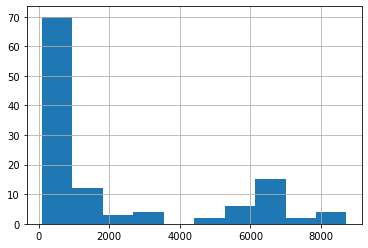

In [204]:
#Смесь распределений: выделяется два класса дорогих и дешевых товаров
data_shuffled['price'].hist()

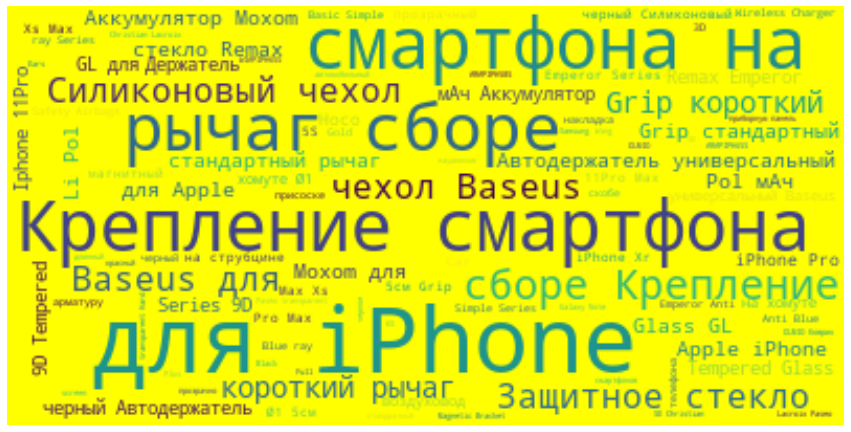

In [189]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in data.name)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=200, background_color="yellow").generate(text)
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [190]:
# подгружаем метрики
#метрики качества (можно взять несколько, R2, MAE, RMSE)
#Средняя абсолютная ошибка (MAE) представляет собой разницу между исходными и прогнозируемыми значениями, извлеченными посредством усредненной абсолютной разницы по набору данных.
#Среднеквадратическая ошибка (RMSE) это частота ошибок, вычисляемая квадратным корнем из MSE.
#Коэффициент детерминации (R2) - описявает качество модели. Чем выше значение, тем лучше модель (от 0 до 1, 1 идеальный)
#Средняя абсолютнаяпроцентная ошибка (MAPE) - процент кол-ва ошибок
#Среднеквадратическая ошибка (MSE) - представляет собой разницу между исходным и прогнозируемым значениями, извлеченными путем возведения в квадрат средней разницы по набору данных.
from sklearn import metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [205]:
#2. Постройте модели простой линейной регрессии
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)

# Обучили модель на тренировочной выборке 
lin_reg.fit(X_train,y_train)
# Сделали прогнозы на тестовой выборке 
lin_reg_predict = lin_reg.predict(X_test)
measured_metrics["lin_reg"] = dataframe_metrics(y_test, lin_reg_predict)
measured_metrics

,error_type,lin_reg
0,MAE,823.507830
1,RMSE,1211.144041
2,R2,0.846835
3,MAPE,101.108296
